In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
from pathlib import Path
from glob import glob
import pandas as pd
from tqdm import tqdm
import os
from  sklearn.metrics import pairwise_distances

plt.rcParams.update({'font.size': 40})


In [23]:
def show_cities(lines):
    plt.figure(figsize=(8,12));plt.axis('off')
    plt.scatter(lines[:, 1], lines[:, 0])
    
def plot_path(positions, solution, pre_title=''):
    
    plt.title(f"{pre_title} {get_path_distance(solution, distance):0.0f}")
    
    plt.scatter(positions[:, 1], positions[:, 0])
    
    for idx in range(len(solution)):    
        pt1 = solution[idx]
        pt2 = solution[idx+1] if idx+1 != len(solution) else solution[0]
        st  = positions[pt1]
        end = positions[pt2]
        plt.plot([st[1], end[1]], [st[0], end[0]], 'r')
        
def get_path_distance(solution, distance):
    sum_dist = 0
    len_sol = len(solution)
    for idx in (solution):
        start  = solution[idx]
        end    = solution[(idx+1)%len_sol]
        sum_dist += distance[start, end]
    return sum_dist


def get_children(solution):    
    children = []
    len_sol = len(solution)
    for idx in range(len_sol):
        ridx = (idx+1) % len_sol
        temp = solution.copy()
        temp[idx], temp[ridx] = temp[ridx], temp[idx]
        children.append(temp)
    return children

def get_best_child(solution, distance):
    the_child = -1
    best_dist = 9e20
    children  = get_children(solution)
    for child in children:
        dist = get_path_distance(child, distance)
        if dist < best_dist:
            the_child  = child
            best_dist = dist

    return np.array(the_child), best_dist

def get_best_child_r(solution, distance):
    children  = -1
    best_dist = 9e20
    len_sol   = len(solution) 
    for idx in range(len_sol):
        ridx  = np.random.randint(len_sol)
        temp  = solution.copy()
        temp[idx], temp[ridx] = temp[ridx], temp[idx]
        dist = get_path_distance(temp, distance)
        if dist < best_dist:
            children = temp
            best_dist = dist

    
    return children, best_dist

def get_best_child_n(actual_solution, distance):
    children  = -1
    best_dist = 9e20
    
    len_sol = len(actual_solution)
    for idx in range(len_sol):
        some_solution = actual_solution.copy()
        curr = some_solution[idx]
        bef  = some_solution[idx-1]
        after = some_solution[(idx+1)%len_sol]

        cand = distance[curr].argsort()[1:3]
        cand = cand[0] if cand[0] != bef else cand[1]

        idx1 = np.where(some_solution==after)[0][0]
        idx2 = np.where(some_solution==cand)[0][0]
        some_solution[idx1], some_solution[idx2] = some_solution[idx2], some_solution[idx1]
        
        dist = get_path_distance(some_solution, distance)
        if dist < best_dist:
            children = some_solution
            best_dist = dist
        
    return children, best_dist

In [24]:
countrie = ["Qatar", "qa194"] # Optimal tour has length 9352.
#countrie = ["Djibouti", "dj38"] # Optimal tour has length 6656.
save_path = f"extra/{countrie[0]}"
data_path = f"{save_path}/data.tsv"
Path(save_path).mkdir(exist_ok=True, parents=True)

In [25]:
if not Path(data_path).exists():
    cmd = f"wget http://www.math.uwaterloo.ca/tsp/world/{countrie[1]}.tsp -O {data_path}"
    os.system(cmd)

In [26]:
with open(data_path, "r") as f:
    lines = f.readlines()
lines = map(lambda x: x.replace('\n', ''), lines)
lines = list(filter(lambda x: x.split(" ")[0].isnumeric(), list(lines)));
lines = list(map(lambda x: list(map(lambda y: float(y), x.split(" ")))[1:], lines))
positions = np.array(lines)

num_cities       = len(lines)
initial_solution = list(range(num_cities))


Xmin = positions[:, 0].min()
Ymin = positions[:, 1].min()

#positions[:, 0] -= Xmin
#positions[:, 1] -= Ymin

Xmax = positions[:, 0].max()
Ymax = positions[:, 1].max()

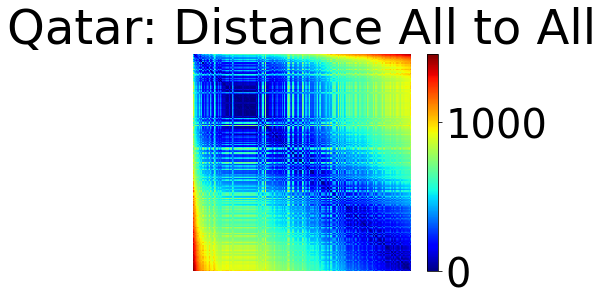

In [27]:
distance = pairwise_distances(positions)

plt.title(f"{countrie[0]}: Distance All to All")
plt.imshow(distance, cmap='jet')
plt.colorbar();plt.axis('off');

In [28]:
def hill_climber(positions, distance, child_code='D', rseed=10):
    actual = np.array((range(num_cities)))
    np.random.seed(rseed)
    np.random.shuffle(actual)
    dist = get_path_distance(actual, distance)
    t = (range(10_000))
    for idx in t:
        if child_code == 'R':
            child, child_dist = get_best_child_r(actual, distance)
        elif child_code == 'D':
            child, child_dist = get_best_child(actual, distance)
        elif child_code == 'N':
            child, child_dist = get_best_child_n(actual, distance)
        
        if child_dist < dist:
            dist = child_dist
            actual = child
        else:
            break
        
    return actual, dist, idx

In [29]:
plt.ioff()

code = 'D'
actual, dist, curr_iter = -1, 9999999999, -1
Path(f"{save_path}/neighborhood/").mkdir(parents=True, exist_ok=True)

t = tqdm(range(10))
for idx in t:
    new, new_dist, niter = hill_climber(positions, distance, child_code=code, rseed=idx)
    if new_dist < dist:
        actual    = new
        dist      = new_dist
        curr_iter = niter

    plt.figure(figsize=(8,12));plt.axis('off')
    plot_path(positions, new, f"N: {niter}; Distance")
    plt.savefig(f"{save_path}/neighborhood/{idx:03d}.jpg")

    t.set_description(f"Dist {dist:0.0f}")
    plt.close()
    
plt.figure(figsize=(8*1,12));plt.axis('off')
plot_path(positions, actual, f"N: {curr_iter}; Distance")
plt.savefig(f"{save_path}/neighborhood/Best.jpg")
plt.close()    

Dist 63618: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


In [30]:
code = 'R'
actual_r, dist_r, curr_iter_r = -1, 9999999999, -1
Path(f"{save_path}/random/").mkdir(parents=True, exist_ok=True)

t = tqdm(range(10))
for idx in t:
    new, new_dist, niter = hill_climber(positions, distance, child_code=code, rseed=idx)
    if new_dist < dist_r:
        actual_r = new
        dist_r = new_dist
        curr_iter_r = niter
        
    plt.figure(figsize=(8,12));plt.axis('off')
    plot_path(positions, new, f"N: {niter}; Distance")
    plt.savefig(f"{save_path}/random/{idx:03d}.jpg")
    plt.close() 
         
    t.set_description(f"DistR {dist_r:0.0f}")
    
plt.figure(figsize=(8*1,12));plt.axis('off')
plot_path(positions, actual_r, f"N: {curr_iter_r}; Distance")
plt.savefig(f"{save_path}/random/Best.jpg")
plt.close()    

DistR 27023: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


In [31]:
code = 'N'
actual_n, dist_n, curr_iter_n = -1, 9999999999, -1
Path(f"{save_path}/near/").mkdir(parents=True, exist_ok=True)

t = tqdm(range(10))
for idx in t:
    new, new_dist, niter = hill_climber(positions, distance, child_code=code, rseed=idx)
    if new_dist < dist_n:
        actual_n = new
        dist_n = new_dist
        curr_iter_n = niter
    
    plt.figure(figsize=(8,12));plt.axis('off')
    plot_path(positions, new, f"N: {niter}; Distance")
    plt.savefig(f"{save_path}/near/{idx:03d}.jpg")
    plt.close() 
         
    t.set_description(f"DistB {dist_n:0.0f}")

plt.figure(figsize=(8*1,12));plt.axis('off')
plot_path(positions, actual_n, f"N: {curr_iter_n}; Distance")
plt.savefig(f"{save_path}/near/Best.jpg")
plt.close()   

DistB 31647: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


In [ ]:
started = np.array(list(range((num_cities))))
shuffle = np.array(list(range((num_cities))))
np.random.seed(10)
np.random.shuffle(shuffle)

In [ ]:
plt.figure(figsize=(8*5,12))
plt.subplot(151);plt.axis('off')
plot_path(positions, initial_solution, "inital")
plt.subplot(152);plt.axis('off')
plot_path(positions, shuffle, "Shuffle")
plt.subplot(153);plt.axis('off')
plot_path(positions, actual, "Neighborhood Perm")
plt.subplot(154);plt.axis('off')
plot_path(positions, actual_r, "Random Perm")
plt.subplot(155);plt.axis('off')
plot_path(positions, actual_n, "Near Perm")
plt.savefig(f"{save_path}/summary.png")